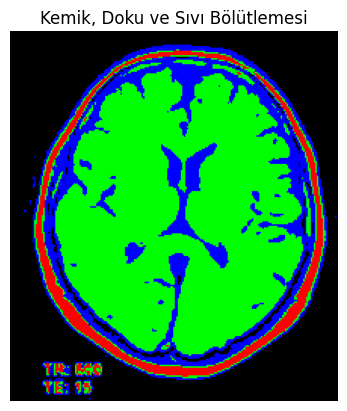

In [2]:
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

def dbscan(X, eps, min_samples):
    # Gürültü etiketi
    NOISE = 0

    # Veri noktalarının sayısı
    n_points = X.shape[0]

    # Veri noktalarının etiketleri (başlangıçta hepsi -1)
    labels = np.full(n_points, -1)

    # Ziyaret edilen noktaların takibi için kullanılan set
    visited = set()

    # Noktaların çevresindeki komşu noktaları bulan fonksiyon
    def region_query(point_id):
        neighbors = kdtree.query_radius(X[point_id].reshape(1, -1), r=eps)[0] #komsu noktalarin indislerini icerir
        return neighbors

    # Bir noktayı ziyaret etmek için kullanılan fonksiyon
    def expand_cluster(point_id, cluster_id):
        labels[point_id] = cluster_id
        neighbors = region_query(point_id)
        for neighbor_id in neighbors:
            if neighbor_id not in visited:
                visited.add(neighbor_id)
                neighbor_neighbors = region_query(neighbor_id)
                if len(neighbor_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, neighbor_neighbors))
            if labels[neighbor_id] == NOISE:
                labels[neighbor_id] = cluster_id

    # KD-Tree oluşturma
    kdtree = KDTree(X)

    # DBSCAN algoritmasını çalıştırma
    cluster_id = 0
    for point_id in range(n_points):
        if point_id in visited:
            continue
        visited.add(point_id)
        neighbors = region_query(point_id)
        if len(neighbors) < min_samples:
            labels[point_id] = NOISE
        else:
            cluster_ids = []
            for neighbor_id in neighbors:
                if labels[neighbor_id] != NOISE:
                    cluster_ids.append(labels[neighbor_id])

            if len(cluster_ids) == 0:
                cluster_id += 1
                expand_cluster(point_id, cluster_id)
            else:
                cluster_id = min(cluster_ids)
                labels[point_id] = cluster_id
                for neighbor_id in neighbors:
                    if labels[neighbor_id] == NOISE:
                        labels[neighbor_id] = cluster_id


    return labels


# MR görüntüsünü yükleme ve grayscale'e dönüştürme
image = plt.imread('beyin_mr_8.jpeg')
image_gray = np.mean(image, axis=2)

# MR görüntüsünü düzleştirme
X = image_gray.reshape(-1, 1)

# Eşik değerleri belirleme
bone_threshold = 160  # Kemik için eşik değeri
tissue_threshold = 100  # Doku için eşik değeri
fluid_threshold = 30  # Sıvı için eşik değeri

# Yeni etiket değerleri atanması
labels = np.zeros(X.shape[0], dtype=int)

# Kemik, doku ve sıvı bölgelerini belirleme
for i, pixel in enumerate(X):
    if pixel >= bone_threshold:
        labels[i] = 1  # Kemik
    elif pixel >= tissue_threshold:
        labels[i] = 2  # Doku
    elif pixel >= fluid_threshold:
        labels[i] = 3  # Sıvı

# DBSCAN parametreleri
eps = 0.5
min_samples = 2

# DBSCAN algoritmasını çalıştırma
segmented_labels = dbscan(X, eps, min_samples)

# DBSCAN sonuçlarını kullanarak etiketleri güncelleme
for i, label in enumerate(segmented_labels):
    if label != -1:
        labels[i] = 4  # DBSCAN tarafından belirlenen bölge

# Sonuçları yeniden şekillendirme
segmented_image = labels.reshape(image.shape[:2])

# Renk paleti
colors = [
    [0, 0, 0],        # Siyah (Gürültü)
    [255, 0, 0],      # Kırmızı (Kemik)
    [0, 255, 0],      # Yeşil (Doku)
    [0, 0, 255],      # Mavi (Sıvı)
    [255, 255, 0],    # Sarı (DBSCAN)
]

# Renklendirme
segmented_image_color = np.zeros_like(image)
for i, color in enumerate(colors):
    segmented_image_color[segmented_image == i] = color

# Görselleştirme
plt.imshow(segmented_image_color)
plt.axis('off')
plt.title('Kemik, Doku ve Sıvı Bölütlemesi')
plt.show()
